<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 非線形回帰ー知識編

In [32]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

## 特徴量の非線形化

データの分布がある程度線形であれば線形モデルを使えばよいですが、  
線形関係が見られないようなデータでは、線形モデルだとどうしてもモデルの精度が下がってしまいます。

例えば、以下のような分布です。  
（正弦関数にノイズを加えたデータ）

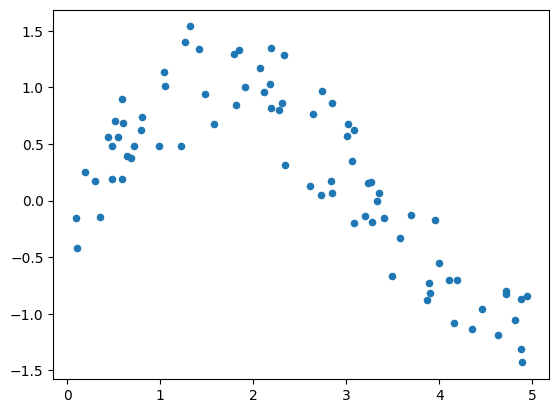

In [12]:
# ランダムなデータ生成
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# プロット
plt.scatter(X, y, s=20, label='Data')

この分布では、線形関係があるようには見えません。

### 多項式特徴量

このような場合における対策の一つが、特徴量を**多項式化**することです。

例として、以下のような線形回帰式を想定します。
$$
f(X)=\theta_0+\theta_1X_1
$$

この特徴量$X$を多項式化し（多項式特徴量）、多項式回帰モデルとします。

$$
f(X)=\theta_0+\theta_1X_1+\theta_2X_1^2+\theta_3X_1^3+\cdots+\theta_dX_1^d
$$

実際には3を超える$d$を使うことはほとんどないようです。

まずは、先ほどの分布に対して線形回帰モデルを使ってみましょう。

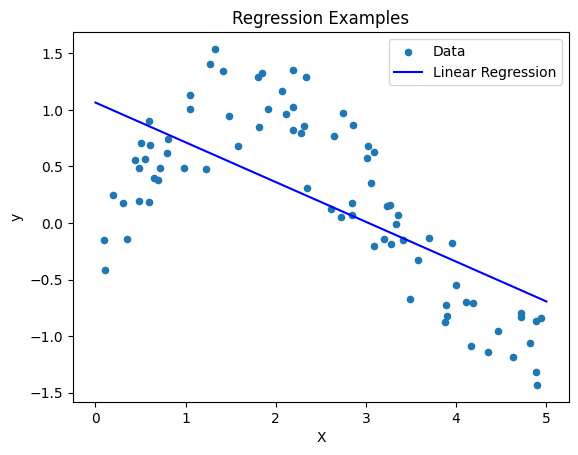

In [13]:
# ランダムなデータ生成
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# プロット用のデータ
X_plot = np.linspace(0, 5, 100)[:, np.newaxis]

# 直線回帰
linear_model = LinearRegression()
linear_model.fit(X, y)
y_linear_pred = linear_model.predict(X_plot)

# プロット
plt.scatter(X, y, s=20, label='Data')
plt.plot(X_plot, y_linear_pred, color='b', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regression Examples')
plt.legend()
plt.show()


次に、多項式回帰モデルを使ってみましょう。

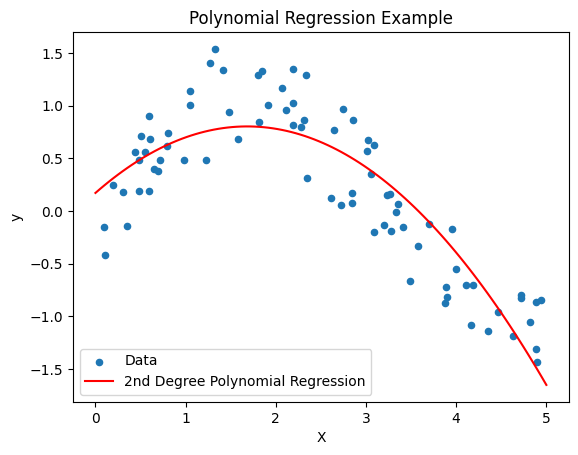

In [14]:
# ランダムなデータ生成
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# 多項式特徴量の生成
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 多項式回帰モデルの学習
model = LinearRegression()
model.fit(X_poly, y)

# プロット用のデータ
X_plot = np.linspace(0, 5, 100)[:, np.newaxis]
X_plot_poly = poly.transform(X_plot)
y_pred = model.predict(X_plot_poly)

# プロット
plt.scatter(X, y, s=20, label='Data')
plt.plot(X_plot, y_pred, color='r', label='2nd Degree Polynomial Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Polynomial Regression Example')
plt.legend()
plt.show()


かなり精度よく予想できていそうです。

多項式回帰モデルは結果をplotすると非線形のように見えますが、**非線形モデルではありません**。  
（$x$という特徴量と$x^2$という別の新たな特徴量と考えるイメージです）

多項式回帰モデルを学習させているところは以下の通りです。

- `degree`：$d$にあたるもの
- `include_bias`：バイアス項（切片に対する項）。基本不要なのでFalseを指定することが多い。
- `.fit_transform()`：多項式特徴量を生成する

In [15]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly[0:3]

array([[0.093949  , 0.00882642],
       [0.10109199, 0.01021959],
       [0.19593896, 0.03839208]])

### 交互作用項

次に、特徴量が複数ある場合の線形回帰式を想定します。
$$
f(X)=\theta_0+\theta_1X_1+\theta_2X_2
$$

このとき、多項化だけではなく、  
**交互作用項**という相互に関係のある特徴量を組み合わせることがあります。

$$
f(X)=\theta_0+\theta_1X_1+\theta_2X_2+\theta_3X_1^2+\theta_4X_2^2+\theta_5X_1X_2
$$

`PolynomialFeatures()`クラスでは、この交互作用項も含む形で  
特徴量変換が行われるようです。

## 非線形アルゴリズム

### kNN

**kNN**は、**k Nearest Neighbor**といわれる機械学習アルゴリズムです。  
日本語では**k最近傍法**と呼ばれます。

よく分類のアルゴリズムで使われることが多いようですが、  
回帰問題にも使うことができます。

kNN回帰では、そのデータの近くのk個の学習データを見て、  
それらの学習データの平均値を$x_0$の予測値とします。

$$
\hat{f}(x_0)=\frac{1}{k}\sum_{x_i\in N_0}y_i
$$

- $\hat{f}$：本来求めたい真の回帰の式$f$の推定
- $x_i\in N_0$：$x_0$ から最も近いk個の領域$N_0$の中にある学習データ$x_i$
- $y_i$：学習データの値

図で表すと以下のようになります。  
（参考：https://shorturl.at/nzDEQ ）

![](https://imgur.com/6pNMBY3.png)

kNNのような、数式モデルを使わないアルゴリズムを**ノンパラメトリック**と言います。

#### kNN回帰の実装

<Axes: >

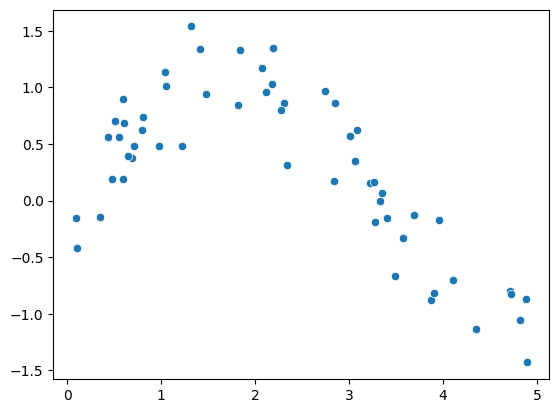

In [17]:
# ランダムなデータ生成
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# プロット
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sns.scatterplot(x=X_train[:, 0], y=y_train)

$k=3$としてモデルの学習を行います。

In [19]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

結果を描画してみます。

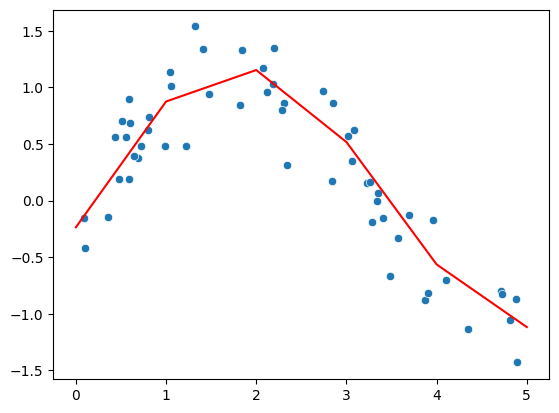

In [26]:
sns.scatterplot(x=X_train[:, 0], y=y_train)
x_axis = np.arange(0, 6).reshape(-1, 1)
y_pred = model.predict(x_axis)
plt.plot(x_axis, y_pred, 'red')

かなり柔軟なモデルになっていることが確認できます。

#### さまざまなkでkNN回帰

最適な$k$を見つけるためには、test error（テストデータに対する誤差）の  
推移をみて決めるのが一般的であるようです。

今回は5kCVでのcv errorをみてみます。

In [39]:
# k=1～20でfor loop
k_list = np.arange(1, 20)
k = 5
n_repeats = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)
score_list = []
for k in k_list:
    model = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    score_list.append(-np.mean(scores))

print(f"Best performance: k={k_list[np.argmin(score_list)]}, cv error={np.min(score_list)}")

Best performance: k=10, cv error=0.09744058718573065


Text(0, 0.5, '5fold cv error')

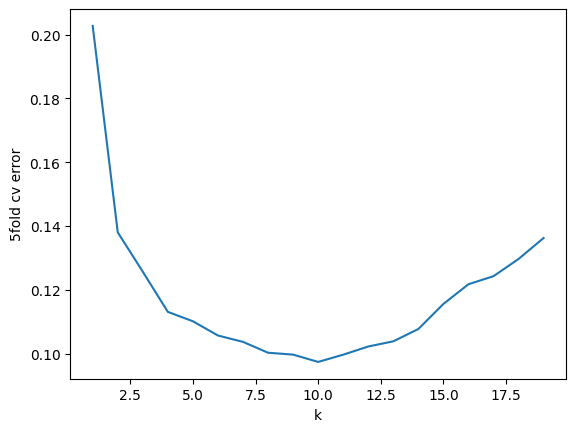

In [40]:
plt.plot(k_list, score_list)
plt.xlabel('k')
plt.ylabel('5fold cv error')

今回の結果は$k=10$の時cv errorが最小になるようです。

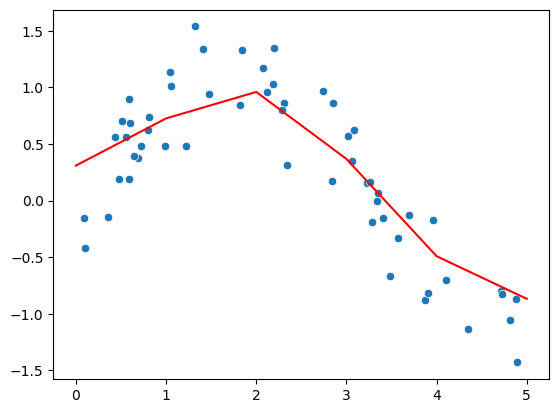

In [41]:
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

sns.scatterplot(x=X_train[:, 0], y=y_train)
x_axis = np.arange(0, 6).reshape(-1, 1)
y_pred = model.predict(x_axis)
plt.plot(x_axis, y_pred, 'red')

kの大きさの変化については、**bias**と**variance**の関係を知る必要があります。  

[こちら](https://datawokagaku.com/bias_variance_tradeoff/)の記事などを参考にして下さい。

#### 線形回帰との比較

＜線形回帰の利点＞

- 学習が簡単
- 解釈しやすい
- 仮説検定が可能

＜線形回帰の欠点＞

- 線形以外のモデルを作ることができない
- 真の$f$が線形な場合以外は概ねkNNより精度が低い


kNNは、大抵の場合線形回帰に比べ精度が高いようですが、  
解釈性が下がるため線形回帰の方が好まれやすいと言われています。